### Single-Shot Readout Calibration for LA Q3

### Using Experiment and Analysis Class, make sure to update qubit #

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 6 # for LA Q3
res_index = 6 # for LA Q3
flux_index = 6 # for LA Q3
TLS_index = 1 # for TLS of interest

2024-03-21 11:04:50,967 - qm - INFO     - Starting session: 166e2903-1f8a-4d51-a89b-30045923a02e


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
# Set the qubit freq, in case I was working with something else
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [5]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-21 11:04:59,216 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-03-21 11:04:59,219 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 11:04:59,243 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-21 11:05:07,132 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.440 GHz, -50.000 MHz)
2024-03-21 11:05:20,278 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## 1D resonator spectroscopy

In [6]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 0.87s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 0.96s


resonator frequency: 6021.000 MHz
Execution stopped by user!


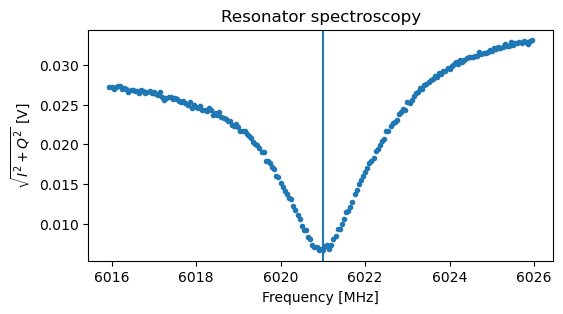

In [7]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
if True:
    machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
    machine.resonators[res_index].lo = machine.resonators[res_index].f_readout + 50E6
    machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy

In [6]:
# for the DC flux
#qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
qubit_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-30E6, 30E6 + 1, 0.5E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E3, cd_time = 20E3, plot_flag = True, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.40s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.49s


resonant frequency: 5392.256 MHz


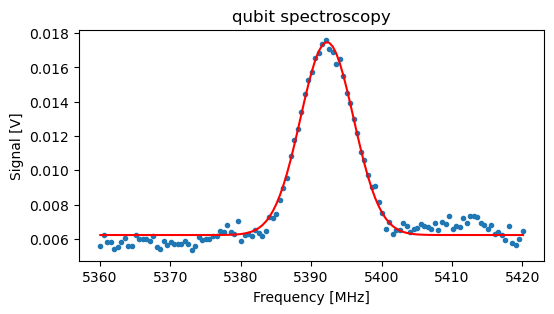

In [8]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

## Measure single-shot I, Q blobs

In [25]:
%matplotlib inline
machine, Ig, Qg, Ie, Qe = Experiment.exp1D.RR.single_shot_IQ_blob(machine.resonators[res_index].f_readout, qubit_index, res_index, flux_index,
                              n_avg = 120E3, cd_time = 50E3, plot_flag = False)

In [26]:
%matplotlib qt
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(Ig, Qg, Ie, Qe, plot_flag=True)


			Fidelity Matrix:
			-----------------
			| 0.936 | 0.064 |
			----------------
			| 0.399 | 0.601 |
			-----------------
			IQ plane rotated by: 132.7°
			Threshold: 2.310e-03
			Fidelity: 76.8%
			


In [27]:
# set the rotation angle
machine.resonators[res_index].rotation_angle = angle.item()
machine.resonators[res_index].ge_threshold = threshold.item()
machine = Analysis.set_machine(machine)

In [27]:
machine.resonators[res_index].readout_pulse_length = 500
machine = Analysis.set_machine(machine)

## optimize single-shot frequency

In [14]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-2E6, 2E6 + 1, 0.02E6)

%matplotlib qt
machine, SNR, res_freq_opt = Experiment.exp1D.RR.single_shot_freq_optimization(res_freq_sweep, qubit_index, res_index, flux_index,
                              n_avg = 50E3, cd_time = 10E3, plot_flag = True)

KeyboardInterrupt: 

In [19]:
machine.resonators[res_index].f_readout = res_freq_opt.tolist() + 0E6
machine.resonators[res_index].lo = machine.resonators[res_index].f_readout + 50E6
machine = Analysis.set_machine(machine)

In [20]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-02-15 09:23:53,209 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-15 09:23:53,221 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.069 GHz, -50.000 MHz)
2024-02-15 09:24:00,839 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.471 GHz, -50.000 MHz)
2024-02-15 09:24:12,992 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## optimize single-shot amplitude

In [28]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, res_amp_sweep_abs, fidelity, res_amp_opt = Experiment.exp1D.RR.single_shot_amp_optimization(res_amp_sweep, qubit_index, res_index, flux_index,
                              n_avg = 40E3, cd_time = 50E3, plot_flag = True)

some abs amps > 0.5, removed from experiment run
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 210.94s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 210.97s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.00s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.02s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.05s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.07s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.09s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.12s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 211.1

Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.01s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.04s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.06s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.09s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.11s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.14s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.17s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.20s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 213.22s
Progress: [###################################

Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 214.99s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.00s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.01s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.03s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.04s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.06s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.07s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.09s
Progress: [##################################################] 100.0% (n=53/53) --> elapsed time: 215.10s
Progress: [###################################

In [22]:
# Set the value to the maximum obtained above
machine.resonators[res_index].readout_pulse_amp = 0.487554
machine = Analysis.set_machine(machine)

## optimize single-shot readout duration

In [23]:
readout_len = 4E3
ringdown_len = 1E3
division_length = 10

%matplotlib qt
machine, res_duration_sweep, SNR, opt_readout_length = Experiment.exp1D.RR.single_shot_duration_optimization(readout_len, ringdown_len, division_length, 
                            qubit_index, res_index, flux_index, n_avg = 50E3, cd_time = 20E3, plot_flag = True)

Integration weights chunk-size length in clock cycles: 10
The readout has been sliced in the following number of divisions 125
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 25.75s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 26.14s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 26.58s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 27.02s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 27.43s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 27.84s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 28.28s
Progress: [##################################################] 100.0% (n=50000/500

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 56.11s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 56.52s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 56.94s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 57.34s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 57.74s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 58.16s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 58.57s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 58.99s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elap

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 86.84s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 87.29s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 87.72s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 88.15s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 88.56s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 89.00s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 89.45s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 89.89s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elap

In [24]:
machine.resonators[res_index].readout_pulse_length = 672
machine = Analysis.set_machine(machine)